In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import random

import pollution

import matplotlib.pyplot as plt
import matplotlib
from tqdm import trange
import tqdm
import os
import imageio.v2 as imageio
import math
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import networkx as nx
import os
import math
import matplotlib.ticker as mtick
import ipywidgets as widgets
from scipy.optimize import minimize_scalar, minimize
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

font = {        'size'   : 20}
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 5),
          'font.family':'sans-serif',
          'font.sans-serif':'Nimbus Sans'}
mpl.rc('font', **font)
plt.rcParams.update(params)
# %matplotlib notebook

In [29]:
folder='Data/Fixed Strategy/'
N = 50
density_str = f'N{N}'
s = ['Two cost fixed mean/'+density_str+'/',
     'Two cost by strategy/'+density_str+'/']
means = ['04_','08_']
data={}
for m in means:
    pcp = np.loadtxt(folder+s[0]+m+'pcp.csv').reshape(4,len(np.arange(0,1.05,0.05)),50)
    pcp_type = np.loadtxt(folder+s[0]+m+'pcp_type.csv').reshape(2,2,4,len(np.arange(0,1.05,0.05)),50)
    cc = np.loadtxt(folder+s[0]+m+'cc.csv').reshape(4,len(np.arange(0,1.05,0.05)),50)
    cc_type = np.loadtxt(folder+s[0]+m+'cc_type.csv').reshape(2,2,4,len(np.arange(0,1.05,0.05)),50)
    R = np.array([[np.corrcoef(cc[i,j,:],pcp[i,j,:])[1,0] for j in range(cc.shape[1])] 
                  for i in range(cc.shape[0])])
    R_type = np.array([[[np.corrcoef((cc_type[k,i,j,:]),
                                        (pcp_type[k,i,j,:]))[1,0] 
                         for j in range(cc_type.shape[2])] 
                        for i in range(cc_type.shape[1])] 
                       for k in range(cc_type.shape[0])])
    R[np.isnan(R)] = 0
    R_type[np.isnan(R_type)]=0
    data['fm:'+m] = [pcp,pcp_type,cc,cc_type,R,R_type]
# for m in means:
#     pcp = np.loadtxt(folder+s[1]+m+'pcp.csv').reshape(4,len(np.arange(0,1.05,0.05)),50)
#     pcp_type = np.loadtxt(folder+s[1]+m+'pcp_type.csv').reshape(2,4,len(np.arange(0,1.05,0.05)),50)
#     cc = np.loadtxt(folder+s[1]+m+'cc.csv').reshape(4,len(np.arange(0,1.05,0.05)),50)
#     cc_type = np.loadtxt(folder+s[1]+m+'cc_type.csv').reshape(2,4,len(np.arange(0,1.05,0.05)),50)
#     R = np.array([[np.corrcoef(cc[i,j,:],pcp[i,j,:])[1,0] for j in range(cc.shape[1])] 
#                   for i in range(cc.shape[0])])
#     R_type = np.array([[[np.corrcoef((cc_type[k,i,j,:]),
#                                         (pcp_type[k,i,j,:]))[1,0] 
#                          for j in range(cc_type.shape[2])] 
#                         for i in range(cc_type.shape[1])] 
#                        for k in range(cc_type.shape[0])])
#     R[np.isnan(R)] = 0
#     R_type[np.isnan(R_type)]=0
#     data['bs:'+m] = [pcp,pcp_type,cc,cc_type,R,R_type]

D=[d for d in range(N//5,N,N//5)]
runs=50
mu_min=np.arange(0,1.05,0.05)
D_corners = [d/N for d in range(N//10,N,N//5)]
mu_rich_corners = np.diff(np.array([-0.05]+list(mu_min)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)
mu_mesh,D_mesh = np.meshgrid(mu_rich_corners,D_corners)
mu_grid,D_grid = np.meshgrid(mu_min,D)

lims = [[min([np.nanmean(data[k][i],axis=-1).min() for k in data.keys()]),
         max([np.nanmean(data[k][i],axis=-1).max() for k in data.keys()])] for i in range(6)]
lims[-2:] = [[-1,1],[-1,1]]
# lims = [[-22,0],[0,0],[0.14,1],[0,0],[-1,1],[-1,1]]
print(lims)

[[-7.279385784577584, -0.4172154469480099], [-21.619205883051226, 0.42542293252771196], [0.3056, 0.89], [0.21176190476190473, 1.0], [-1, 1], [-1, 1]]


In [6]:
data.keys()

dict_keys(['fm:04_', 'fm:08_', 'bs:04_', 'bs:08_'])

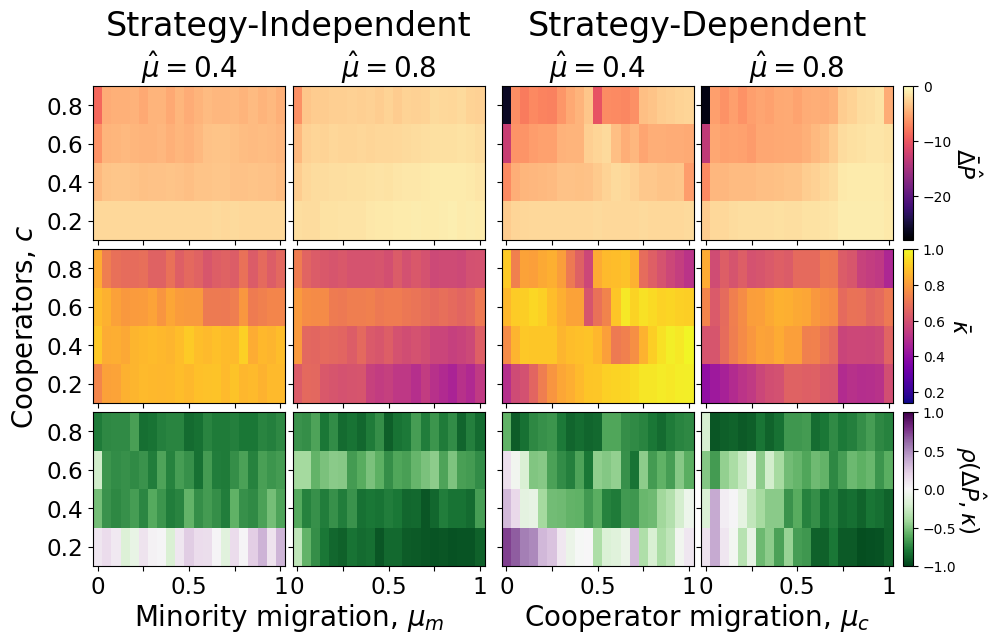

In [8]:
fig,axs=plt.subplots(figsize=(10,6),ncols=5,nrows=3,sharex=True,sharey=True,
                     gridspec_kw=dict(width_ratios=[1,1,0.01,1,1]))
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)
cmaps=['magma','plasma','PRGn_r']
labels = [r'$\bar{\Delta}\hat{P}$',r'$\bar{\kappa}$',r'$\rho(\Delta\hat{P},\kappa)$']
ims=[0,0,0]
for i,k in enumerate(data.keys()):
    if i>=2:
        i+=1
    ims[0]=axs[0,i].pcolormesh(mu_mesh,1-D_mesh,np.nanmean(data[k][0],axis=-1),cmap=cmaps[0],
                        vmax=lims[0][1],vmin=lims[0][0]) # pcp
    ims[1]=axs[1,i].pcolormesh(mu_mesh,1-D_mesh,np.nanmean(data[k][2],axis=-1),cmap=cmaps[1],
                        vmin=lims[2][0],vmax=lims[2][1]) # cc
    ims[2]=axs[2,i].pcolormesh(mu_mesh,1-D_mesh,data[k][4],cmap=cmaps[2],
                        vmin=lims[4][0],vmax=lims[4][1]) # pcc
    axs[2,i].set_xticks([0,0.25,0.5,0.75,1])
    axs[2,i].set_xticklabels([0,'',0.5,'',1])
    
    
cb=[0,0,0]
for j in range(3):
    axs[j,2].set_visible(False)
    pos = axs[j,-1].get_position()
    cax = fig.add_axes([pos.xmax+0.01,pos.ymin,
                       0.01,pos.ymax-pos.ymin])    
    cb[j]=fig.colorbar(ims[j],cax=cax)
    cb[j].set_label(label=labels[j],size='small',rotation=-90,va='center',ha='center',labelpad=10)
    cb[j].ax.tick_params(labelsize=10)
    axs[j,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[j,0].set_yticklabels([0.2,0.4,0.6,0.8])
#     cb[j].ax.xaxis.set_ticks_position('bottom')
#     cb[j].ax.set_title(labels[j],size=20)
# cb[1].ax.set_yticklabels(["{:.0%}".format(i) for i in cb[1].get_ticks()]);

ax_outer=fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X",fontsize='medium')
plt.ylabel("Cooperators, $c$",size='medium')

poss = poss = [[axs[i,j].get_position() for i in range(3)] for j in range(5)]
fig.text((poss[0][2].xmin+poss[1][2].xmax)/2,  
         poss[0][2].ymin-0.1,
         "Minority migration, $\mu_m$",
         ha='center')
fig.text((poss[3][2].xmin+poss[4][2].xmax)/2, 
         poss[2][2].ymin-0.1,
         "Cooperator migration, $\mu_c$",
         ha='center')

fig.text((poss[0][0].xmin+poss[1][0].xmax)/2,  
         poss[0][0].ymax+0.1,
         "Strategy-Independent",
         ha='center',va='center',size='large')
fig.text((poss[3][0].xmin+poss[4][0].xmax)/2, 
         poss[2][0].ymax+0.1,
         "Strategy-Dependent",
         ha='center',va='center',size='large')

fig.text((poss[0][0].xmin+poss[0][0].xmax)/2,
         poss[0][0].ymax+0.015, r'$\hat{\mu}=0.4$',ha='center')
fig.text((poss[3][0].xmin+poss[3][0].xmax)/2,
         poss[3][0].ymax+0.015, r'$\hat{\mu}=0.4$',ha='center')
fig.text((poss[1][0].xmin+poss[1][0].xmax)/2,
         poss[1][0].ymax+0.015, r'$\hat{\mu}=0.8$',ha='center')
fig.text((poss[4][0].xmin+poss[4][0].xmax)/2,
         poss[4][0].ymax+0.015, r'$\hat{\mu}=0.8$',ha='center')

fig.savefig('Figures/Fixed Strategy/'+density_str+'.png',bbox_inches='tight')

Text(0.5, 0, 'Minority cost, $\\mu_m$')

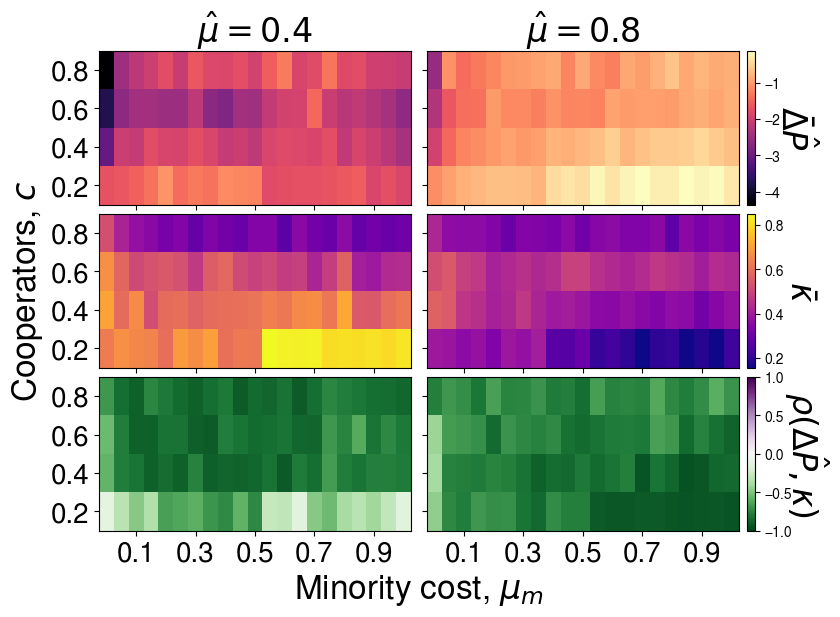

In [9]:
fig,axs=plt.subplots(figsize=(8,6),ncols=2,nrows=3,sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)
cmaps=['magma','plasma','PRGn_r']
labels = [r'$\bar{\Delta}\hat{P}$',r'$\bar{\kappa}$',r'$\rho(\Delta\hat{P},\kappa)$']
ims=[0,0,0]
mu_grid,D_grid=np.meshgrid(mu_min,D)
for i,k in enumerate(['fm:04_', 'fm:08_']):
    ims[0]=axs[0,i].pcolormesh(mu_mesh,1-D_mesh,np.nanmean(data[k][0],axis=-1),cmap=cmaps[0],
                        vmax=lims[0][1],vmin=lims[0][0]) # pcp
#     ims[0]=axs[0,i].pcolormesh(mu_mesh,1-D_mesh,
#                                np.nanmean(data[k][0],axis=-1)/(1-D_grid),
#                                cmap=cmaps[0])# log(pcp/c)
    ims[1]=axs[1,i].pcolormesh(mu_mesh,1-D_mesh,np.nanmean(data[k][2],axis=-1),cmap=cmaps[1],
                        vmin=lims[2][0],vmax=lims[2][1]) # cc
    ims[2]=axs[2,i].pcolormesh(mu_mesh,1-D_mesh,data[k][4],cmap=cmaps[2],
                        vmin=lims[4][0],vmax=lims[4][1]) # pcc
    axs[2,i].set_xticks(np.arange(0.1,1,0.2))
#     axs[2,i].set_xticklabels([0,'',0.5,'',1])
axs[0,0].set_title("$\hat{\mu}=0.4$",size='large')
axs[0,1].set_title("$\hat{\mu}=0.8$",size='large')
    
    
cb=[0,0,0]
for j in range(3):
#     axs[j,2].set_visible(False)
    pos = axs[j,-1].get_position()
    cax = fig.add_axes([pos.xmax+0.01,pos.ymin,
                       0.01,pos.ymax-pos.ymin])    
    cb[j]=fig.colorbar(ims[j],cax=cax)
    cb[j].set_label(label=labels[j],size='large',rotation=-90,va='center',ha='center',labelpad=10)
    cb[j].ax.tick_params(labelsize=10)
    axs[j,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[j,0].set_yticklabels([0.2,0.4,0.6,0.8])
#     cb[j].ax.xaxis.set_ticks_position('bottom')
#     cb[j].ax.set_title(labels[j],size=20)
# cb[1].ax.set_yticklabels(["{:.0%}".format(i) for i in cb[1].get_ticks()]);

ax_outer=fig.add_subplot(111, frameon=False)
ax_outer.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X",fontsize='medium')
ax_outer.set_ylabel("Cooperators, $c$",size='large')
ax_outer.set_xlabel("Minority cost, $\mu_m$",size='large')

# poss = poss = [[axs[i,j].get_position() for i in range(3)] for j in range(5)]
# fig.text((poss[0][2].xmin+poss[1][2].xmax)/2,  
#          poss[0][2].ymin-0.1,
#          "Minority migration, $\mu_m$",
#          ha='center')
# fig.text((poss[3][2].xmin+poss[4][2].xmax)/2, 
#          poss[2][2].ymin-0.1,
#          "Cooperator migration, $\mu_c$",
#          ha='center')

# fig.text((poss[0][0].xmin+poss[1][0].xmax)/2,  
#          poss[0][0].ymax+0.1,
#          "Strategy-Independent",
#          ha='center',va='center',size='large')
# fig.text((poss[3][0].xmin+poss[4][0].xmax)/2, 
#          poss[2][0].ymax+0.1,
#          "Strategy-Dependent",
#          ha='center',va='center',size='large')

# fig.text((poss[0][0].xmin+poss[0][0].xmax)/2,
#          poss[0][0].ymax+0.015, r'$\hat{\mu}=0.4$',ha='center')
# fig.text((poss[3][0].xmin+poss[3][0].xmax)/2,
#          poss[3][0].ymax+0.015, r'$\hat{\mu}=0.4$',ha='center')
# fig.text((poss[1][0].xmin+poss[1][0].xmax)/2,
#          poss[1][0].ymax+0.015, r'$\hat{\mu}=0.8$',ha='center')
# fig.text((poss[4][0].xmin+poss[4][0].xmax)/2,
#          poss[4][0].ymax+0.015, r'$\hat{\mu}=0.8$',ha='center')

# fig.savefig('Figures/Fixed Strategy/N50_two_cost_fixed_mean.png',bbox_inches='tight')

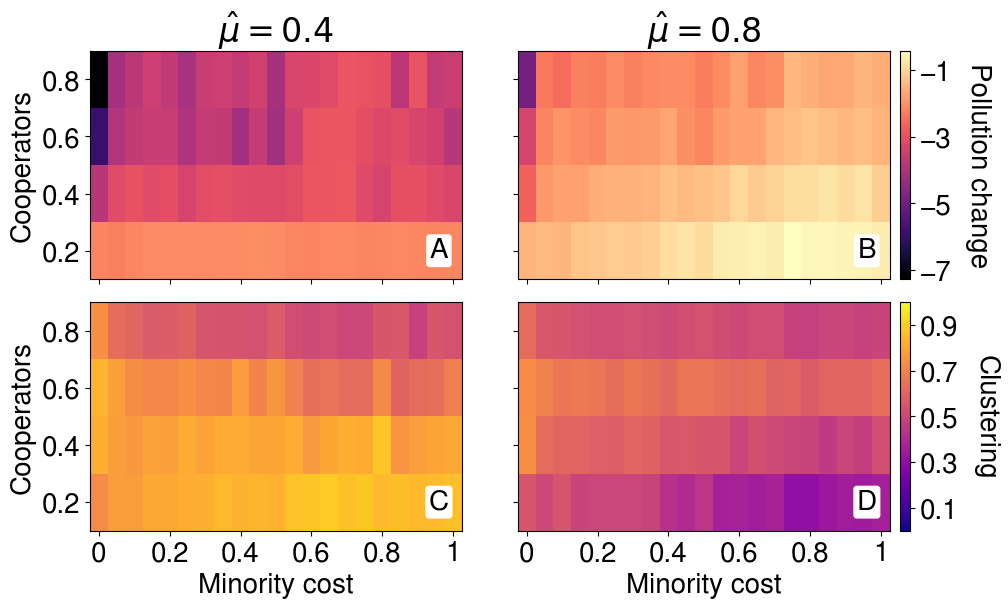

In [33]:
fig,axs=plt.subplots(figsize=(10,6),ncols=2,nrows=2,
                     sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.15,
                    hspace=0.1)
cmaps=['magma','plasma','PRGn_r']
labels = ['Pollution change','Clustering',r'$\rho(\Delta\hat{P},\kappa)$']
ims=[0,0,0]
mu_grid,D_grid=np.meshgrid(mu_min,D)
for i,k in enumerate(['fm:04_', 'fm:08_']):
    ims[0]=axs[0,i].pcolormesh(mu_mesh,1-D_mesh,np.nanmean(data[k][0],axis=-1),cmap=cmaps[0],
                        vmax=lims[0][1],vmin=lims[0][0]) # pcp
#     ims[0]=axs[0,i].pcolormesh(mu_mesh,1-D_mesh,
#                                np.nanmean(data[k][0],axis=-1)/(1-D_grid),
#                                cmap=cmaps[0])# log(pcp/c)
    ims[1]=axs[1,i].pcolormesh(mu_mesh,1-D_mesh,np.nanmean(data[k][2],axis=-1),cmap=cmaps[1],
                        vmin=0,vmax=1) # cc
    axs[-1,i].set_xticks(np.arange(0,1.1,0.2))
    axs[-1,i].set_xticklabels([0,0.2,0.4,0.6,0.8,1])
axs[0,0].set_title("$\hat{\mu}=0.4$",size='large')
axs[0,1].set_title("$\hat{\mu}=0.8$",size='large')
    
    
cb=[0,0,0]
ctick_vals=[np.arange(np.floor(lims[0][0])-1,np.ceil(lims[0][1])+1,2),
            np.arange(0.1,1.1,0.2)]
# ctick_labs=[np.arange(-8,0,1).tolist(),np.arange(0,1.1,0.1).tolist()]
# ctick_labs[0][1::2]=['']*len(ctick_labs[0][1::2])
# ctick_labs[1][0::2]=['']*len(ctick_labs[1][0::2])
for j in range(2):
#     axs[j,2].set_visible(False)
    pos = axs[j,-1].get_position()
    cax = fig.add_axes([pos.xmax+0.01,pos.ymin,
                       0.01,pos.ymax-pos.ymin])    
    cb[j]=fig.colorbar(ims[j],cax=cax,ticks=ctick_vals[j])
    cb[j].set_label(label=labels[j],size='medium',rotation=-90,va='bottom',ha='center',labelpad=10)
#     cb[j].ax.set_yticklabels(ctick_labs[j])
#     cb[j].ax.tick_params(labelsize=10)
    axs[j,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[j,0].set_yticklabels([0.2,0.4,0.6,0.8])
    axs[j,0].set_ylabel("Cooperators")
    axs[1,j].set_xlabel("Minority cost")
axs[0,0].text(0.96,0.2,'A',va='center',ha='center',
              bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))
axs[0,1].text(0.96,0.2,'B',va='center',ha='center',
              bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))
axs[1,0].text(0.96,0.2,'C',va='center',ha='center',
              bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))
axs[1,1].text(0.96,0.2,'D',va='center',ha='center',
              bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))

fig.savefig(f'Figures/Fixed Strategy/N{N}_two_cost_fixed_mean.png',bbox_inches='tight')
fig.savefig(f'Figures/Fixed Strategy/N{N}_two_cost_fixed_mean.eps',bbox_inches='tight',format='eps')

In [18]:
ctick_labs[0][1::2] = np.float(np.nan)
print(ctick_labs)

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


ValueError: cannot convert float NaN to integer

# gini coefficients

In [6]:
folder='Data/Fixed Strategy/Two cost fixed mean/N50/'
s=['04_','08_']
pcp = np.stack([np.loadtxt(folder+S+'pcp.csv').reshape(4,len(np.arange(0,1.05,0.05)),50) for S in s])
pcp_type = np.stack([np.loadtxt(folder+S+'pcp_type.csv').reshape(2,2,4,len(np.arange(0,1.05,0.05)),50) for S in s])
cc = np.stack([np.loadtxt(folder+S+'cc.csv').reshape(4,len(np.arange(0,1.05,0.05)),50) for S in s])
cc_type = np.stack([np.loadtxt(folder+S+'cc_type.csv').reshape(2,2,4,len(np.arange(0,1.05,0.05)),50) for S in s])
# R = np.array([[np.corrcoef(cc[i,j,:],pcp[i,j,:])[1,0] for j in range(cc.shape[1])] 
#                   for i in range(cc.shape[0])])
# R_type = np.array([[[np.corrcoef((cc_type[k,i,j,:]),
#                                         (pcp_type[k,i,j,:]))[1,0] 
#                          for j in range(cc_type.shape[2])] 
#                         for i in range(cc_type.shape[1])] 
#                        for k in range(cc_type.shape[0])])
# R[np.isnan(R)] = 0
# R_type[np.isnan(R_type)]=0

In [13]:
pcp_type.shape

(2, 2, 2, 4, 21, 50)

In [8]:
g_pcp = np.abs((pcp_type.sum(axis=2)[:,0]-pcp_type.sum(axis=2)[:,1]))/pcp_type.sum(axis=(1,2))
g_cc = np.abs((cc_type.sum(axis=2)[:,0]-cc_type.sum(axis=2)[:,1]))/cc_type.sum(axis=(1,2))
# p=pcp_type.sum(axis=(1,2))
# g_pcp.shape
# p.shape
# g_pcp.shape

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


IndexError: index 2 is out of bounds for axis 0 with size 2

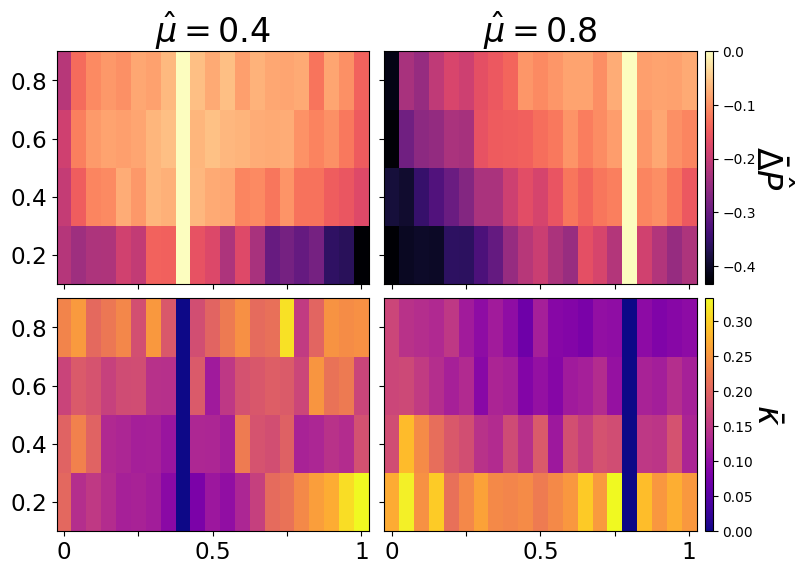

In [10]:
fig,axs=plt.subplots(figsize=(8,6),ncols=2,nrows=2,sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)
cmaps=['magma','plasma','PRGn_r']
labels = [r'$\bar{\Delta}\hat{P}$',r'$\bar{\kappa}$',r'$\rho(\Delta\hat{P},\kappa)$']
ims=[0,0,0]
mu_grid,D_grid=np.meshgrid(mu_min,D)
for i in range(2):
    for j in range(2):
        ims[0]=axs[0,i].pcolormesh(mu_mesh,1-D_mesh,np.nanmean(g_pcp,axis=-1)[i],cmap=cmaps[0]) # pcp
        ims[1]=axs[1,i].pcolormesh(mu_mesh,1-D_mesh,np.nanmean(g_cc,axis=-1)[i],cmap=cmaps[1]) # cc
    axs[-1,i].set_xticks([0,0.25,0.5,0.75,1])
    axs[-1,i].set_xticklabels([0,'',0.5,'',1])
axs[0,0].set_title("$\hat{\mu}=0.4$",size='large')
axs[0,1].set_title("$\hat{\mu}=0.8$",size='large')
    
    
cb=[0,0,0]
for j in range(3):
#     axs[j,2].set_visible(False)
    pos = axs[j,-1].get_position()
    cax = fig.add_axes([pos.xmax+0.01,pos.ymin,
                       0.01,pos.ymax-pos.ymin])    
    cb[j]=fig.colorbar(ims[j],cax=cax)
    cb[j].set_label(label=labels[j],size='large',rotation=-90,va='center',ha='center',labelpad=10)
    cb[j].ax.tick_params(labelsize=10)
    axs[j,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[j,0].set_yticklabels([0.2,0.4,0.6,0.8])
#     cb[j].ax.xaxis.set_ticks_position('bottom')
#     cb[j].ax.set_title(labels[j],size=20)
# cb[1].ax.set_yticklabels(["{:.0%}".format(i) for i in cb[1].get_ticks()]);

ax_outer=fig.add_subplot(111, frameon=False)
ax_outer.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X",fontsize='medium')
ax_outer.set_ylabel("Cooperators, $c$",size='large')
ax_outer.set_xlabel("Minority cost, $\mu_m$",size='large')

In [16]:
np.nanmean(data['fm:08_'][0],axis=-1)

array([[-4.95043582, -2.33103576, -2.53922211, -2.22600911, -2.27323001,
        -2.09917557, -2.23548747, -2.12843721, -2.05267507, -2.08416436,
        -2.28348297, -2.09360268, -1.78161901, -2.14002935, -2.01918706,
        -1.44413611, -1.58341252, -1.68546746, -1.6690656 , -1.47158135,
        -1.58083125],
       [-3.32171179, -2.17659189, -1.97019934, -2.0721065 , -2.15020991,
        -1.88493181, -1.89316057, -1.87697676, -1.72909745, -2.00948416,
        -2.13658334, -1.8559291 , -1.73954825, -1.73887304, -1.45062594,
        -1.37820904, -1.27110706, -1.38174166, -1.4426385 , -1.36889962,
        -1.51291278],
       [-2.67893947, -1.9143401 , -1.7482656 , -1.77903606, -1.5848408 ,
        -1.52320574, -1.52989006, -1.4998882 , -1.31781798, -1.38716016,
        -1.32572058, -1.24804817, -0.99817345, -1.17388813, -1.03554705,
        -0.89024027, -0.87984692, -0.77447606, -0.91570698, -0.80542074,
        -1.11948194],
       [-1.50350189, -1.43342792, -1.48063982, -1.25854337

In [22]:
np.min(np.nanmean(data['fm:04_'][0],axis=-1))

-7.279385784577584

In [21]:
np.min([np.nanmean(data[k][0],axis=-1).min() for k in data.keys()])

-21.619479294846283